# Convert annotations using python script
https://medium.com/@alexppppp/how-to-annotate-keypoints-using-roboflow-9bc2aa8915cd

In [1]:
import json
import os
import cv2
import matplotlib.pyplot as plt

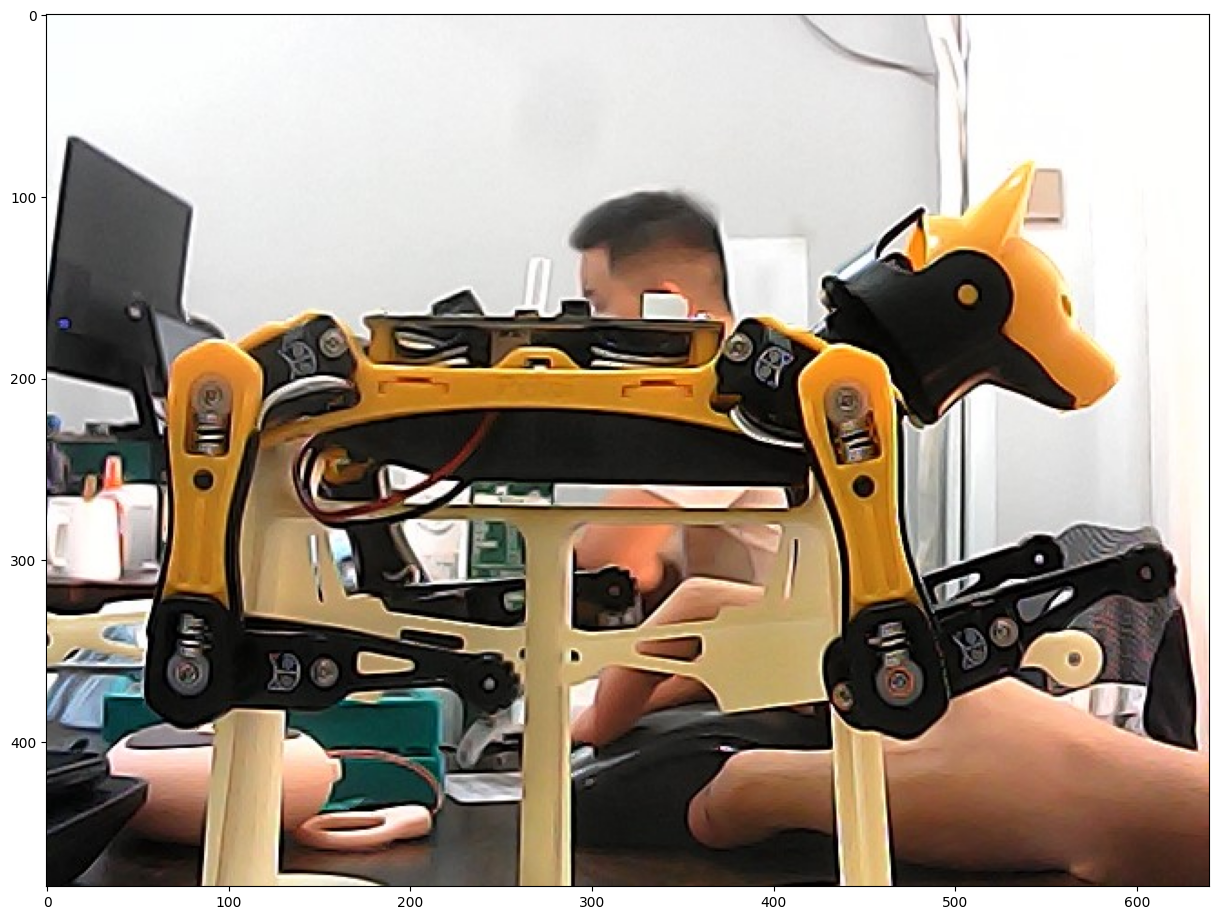

In [3]:
file_image_example = './keypoint/train/images/1.jpg'

img = cv2.imread(file_image_example)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,15))
plt.imshow(img)

In [5]:
file_labels_example = './keypoint/train/labels/1.txt'

with open(file_labels_example) as f:
    lines_txt = f.readlines()
    lines = []
    for line in lines_txt:
        lines.append([int(line.split()[0])] + [round(float(el), 7) for el in line.split()[1:]])

for idx, line in enumerate(lines):
    print("Rectangle {}:".format(idx+1), line)

Rectangle 1: [0, 0.135156, 0.597917, 0.110937, 0.458333]
Rectangle 2: [0, 0.710938, 0.608333, 0.146875, 0.475]
Rectangle 3: [1, 0.141406, 0.434375, 0.048438, 0.060417]
Rectangle 4: [2, 0.121875, 0.753125, 0.05, 0.060417]
Rectangle 5: [1, 0.689063, 0.441667, 0.046875, 0.058333]
Rectangle 6: [2, 0.732812, 0.766667, 0.05, 0.0625]


In [6]:
keypoint_names = ['up', 'down']

# Dictionary to convert rectangles classes into keypoint classes because keypoint classes should start with 0
rectangles2keypoints = {1:0, 2:1}

def converter(file_labels, file_image, keypoint_names):

    img = cv2.imread(file_image)
    img_w, img_h = img.shape[1], img.shape[0]
    
    with open(file_labels) as f:
        lines_txt = f.readlines()
        lines = []
        for line in lines_txt:
            lines.append([int(line.split()[0])] + [round(float(el), 5) for el in line.split()[1:]])

    bboxes = []
    keypoints = []

    # In this loop we convert normalized coordinates to absolute coordinates
    for line in lines:
        # Number 0 is a class of rectangles related to bounding boxes.
        if line[0] == 0:
            x_c, y_c, w, h = round(line[1] * img_w), round(line[2] * img_h), round(line[3] * img_w), round(line[4] * img_h)
            bboxes.append([round(x_c - w/2), round(y_c - h/2), round(x_c + w/2), round(y_c + h/2)])

        # Other numbers are the classes of rectangles related to keypoints.
        # After convertion, numbers of keypoint classes should start with 0, so we apply rectangles2keypoints dictionary to achieve that.
        # In our case:
        # 1 is rectangle for head keypoint, which is 0, so we convert 1 to 0;
        # 2 is rectangle for tail keypoint, which is 1, so we convert 2 to 1.
        if line[0] != 0:
            kp_id, x_c, y_c = rectangles2keypoints[line[0]], round(line[1] * img_w), round(line[2] * img_h)
            keypoints.append([kp_id, x_c, y_c])

    # In this loop we are iterating over each keypoint and looking to which bounding box it matches.
    # Thus, we are matching keypoints and corresponding bounding boxes.
    keypoints_sorted = [[[] for _ in keypoint_names] for _ in bboxes]
    for kp in keypoints:
        kp_id, kp_x, kp_y = kp[0], kp[1], kp[2]
        for bbox_idx, bbox in enumerate(bboxes):
            x1, y1, x2, y2 = bbox[0], bbox[1], bbox[2], bbox[3]
            if x1 < kp_x < x2 and y1 < kp_y < y2:
                keypoints_sorted[bbox_idx][kp_id] = [kp_x, kp_y, 1] # All keypoints are visible
                
    return bboxes, keypoints_sorted

In [7]:
bboxes, keypoints_sorted = converter(file_labels_example, file_image_example, keypoint_names)

print("Bboxes:", bboxes)
print("Keypoints:", keypoints_sorted)

Bboxes: [[52, 177, 122, 397], [408, 178, 502, 406]]
Keypoints: [[[91, 209, 1], [78, 362, 1]], [[441, 212, 1], [469, 368, 1]]]


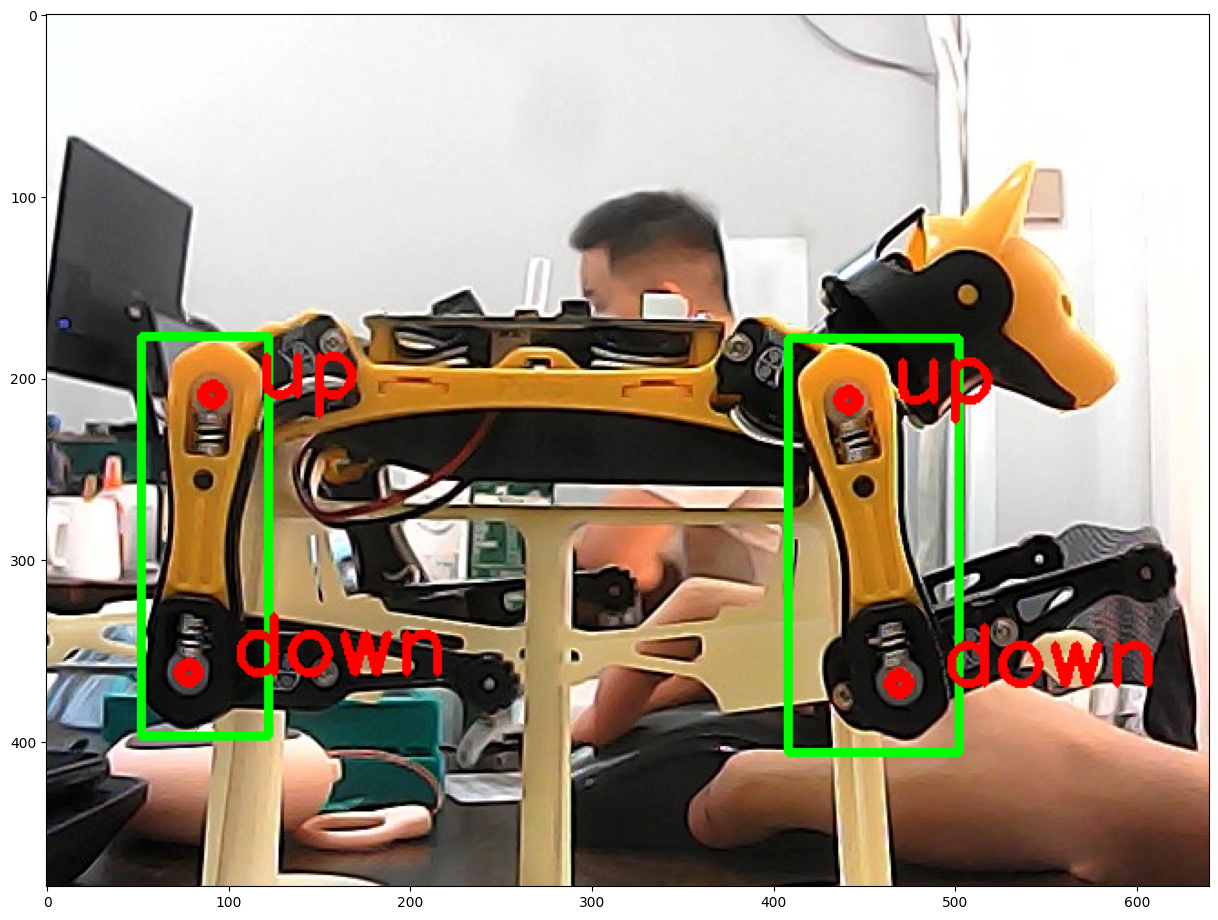

In [8]:
for bbox_idx, bbox in enumerate(bboxes):
    top_left_corner, bottom_right_corner = tuple([bbox[0], bbox[1]]), tuple([bbox[2], bbox[3]])
    img = cv2.rectangle(img, top_left_corner, bottom_right_corner, (0,255,0), 3)
    
    for kp_idx, kp in enumerate(keypoints_sorted[bbox_idx]):
        center = tuple([kp[0], kp[1]])
        img = cv2.circle(img, center, 5, (255,0,0), 5)
        img = cv2.putText(img, " " + keypoint_names[kp_idx], center, cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,0,0), 4)
        
plt.figure(figsize=(15,15))
plt.imshow(img)

In [9]:
def dump2json(bboxes, keypoints_sorted, file_json):
    annotations = {}
    annotations['bboxes'], annotations['keypoints'] = bboxes, keypoints_sorted
    with open(file_json, "w") as f:
        json.dump(annotations, f)

In [10]:
IMAGES = './keypoint/train/images'
LABELS = './keypoint/train/labels'
ANNOTATIONS = './keypoint/train/annotations'

files_names = [file.split('.jpg')[0] for file in os.listdir(IMAGES)]

for file in files_names:
    file_labels = os.path.join(LABELS, file + ".txt")
    file_image = os.path.join(IMAGES, file + ".jpg")
    bboxes, keypoints_sorted = converter(file_labels, file_image, keypoint_names)
    dump2json(bboxes, keypoints_sorted, os.path.join(ANNOTATIONS, file + '.json'))